## LSTM Encoder Decoder Model to Forecast Bus Demand

### Imports

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2023-02-13 22:14:19.082930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-13 22:14:19.328087: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-13 22:14:19.328130: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-13 22:14:20.315780: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Reading Data

In [2]:
data = pd.read_csv("data/preprocessed_data.csv", engine="c")

### Utils

In [3]:
def split_categories(df, column):
    """
    A method that splits dataframe into separate dataframes according to contained groups of given column
    :param df: dataframe
    :param column: string column name that includes groups
    :return: list of dataframes
    """
    df_list = []
    groups = df.groupby(df[column])
    for i in range(len(groups)):
        df_list.append(groups.get_group(i))
    return df_list

In [4]:
def split_sequence(sequence, look_back, forecast_horizon):
    """
    A method that creates time series sequences using given parameters
    :param sequence: dataframe
    :param look_back: number of value(s) as input
    :param forecast_horizon: number of value(s) as target
    :return: numpy arrays for input and target
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [5]:
def evaluate_forecast(y_test, yhat):
    """
    Evaluation metrics with tensorflow
    :param y_test: real target values of test values
    :param yhat: predicted target values from test values
    :return: evaluation scores
    """
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test,yhat)
    print('mae:', mae)
    mse = mse_(y_test,yhat)
    print('mse:', mse)
    mape = mape_(y_test,yhat)
    print('mape:', mape)

### Model

**Model Preparations**

In [6]:
early_stopping_callback = EarlyStopping(
                         monitor="val_loss",
                         min_delta=0.005,
                         patience=10,
                         mode="min"
                        )
rlrop_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.2, mode="min", patience=3, min_lr=0.01)

In [7]:
municipalities = split_categories(data, "municipality_id")

In [8]:
forecast_start = "2017-08-05 06"
forecast_end = "2017-08-19 16"
working_hours_start = 7
working_hours_end = 16
LOOK_BACK = 7
FORECAST_RANGE = 1

In [9]:
epochs = 100
batch_size = 32
validation = 0.1

**Train**

In [10]:
models = []
X_trains = []
y_trains = []
X_tests = []
y_tests = []

for i in municipalities:
    df = i.copy()[["timestamp", "usage"]].set_index("timestamp")

    train_df = df.loc[:"2017-08-05 06:00:00"]
    test_df = df.loc["2017-08-05 06:00:00":]

    n_features = len(train_df.columns)

    split_train = split_sequence(train_df, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
    X_trains.append(split_train[0])
    y_trains.append(split_train[1])
    split_test = split_sequence(test_df, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
    X_tests.append(split_test[0])
    y_tests.append(split_test[1])

    model_enc_dec = Sequential()
    model_enc_dec.add(LSTM(50, activation='relu', input_shape=(LOOK_BACK, n_features)))
    model_enc_dec.add(RepeatVector(FORECAST_RANGE))
    model_enc_dec.add(LSTM(50, activation='relu', return_sequences=True))
    model_enc_dec.add(TimeDistributed(Dense(n_features)))
    model_enc_dec.add(Activation(activation='relu'))
    model_enc_dec.compile(optimizer='rmsprop', loss='mae', run_eagerly=True)
    history = model_enc_dec.fit(split_train[0], split_train[1], epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, rlrop_callback], verbose=1)
    models.append(model_enc_dec)

2023-02-13 22:14:40.198315: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-13 22:14:40.198351: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-13 22:14:40.198376: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sueda-laptop): /proc/driver/nvidia/version does not exist
2023-02-13 22:14:40.198677: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
18/18 [==============================] - 1s 66ms/step - loss: 329.4908 - val_loss: 140.5607 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 1s 59ms/step - loss: 167.4457 - val_loss: 78.6729 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 1s 54ms/step - loss: 123.5511 - val_loss: 55.3854 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 1s 53ms/step - loss: 113.9904 - val_loss: 74.6921 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 1s 53ms/step - loss: 107.5172 - val_loss: 67.4013 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 1s 53ms/step - loss: 102.1410 - val_loss: 75.4414 - lr: 0.0010
Epoch 7/100
18/18 [==============================] - 1s 53ms/step - loss: 104.6363 - val_loss: 87.4047 - lr: 0.0010
Epoch 8/100
18/18 [==============================] - 1s 53ms/step - loss: 115.8587 - val_loss: 50.9120 - lr: 0.0010
Epoch 9/100
18/18 [==============================] - 1s 52ms/step - los

**Predict**

In [11]:
yhats = []
for i in range(len(models)):
    yhats.append(models[i].predict(X_tests[i]))

5/5 [==============================] - 0s 27ms/step


**Visualize**

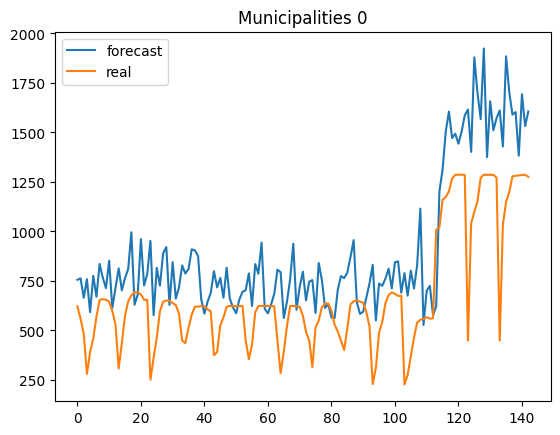

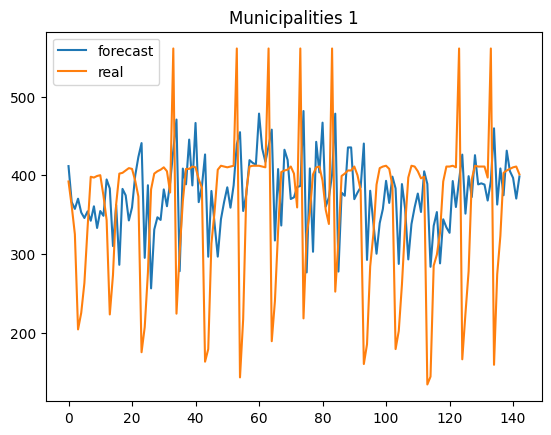

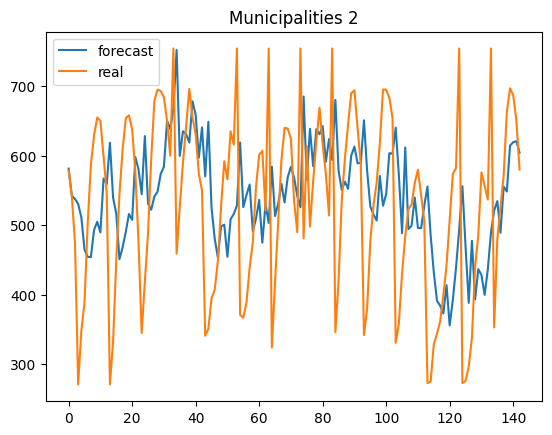

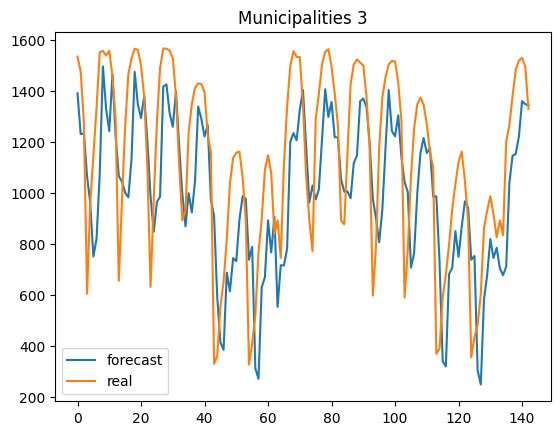

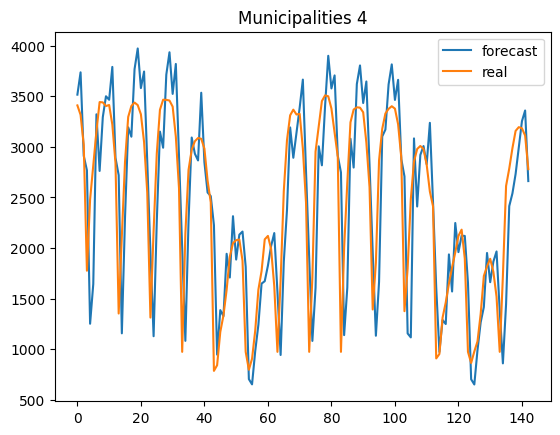

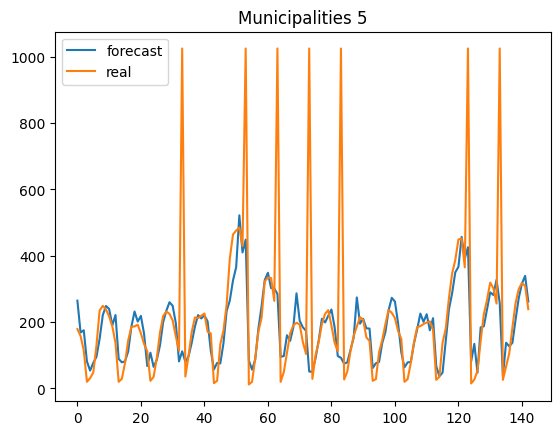

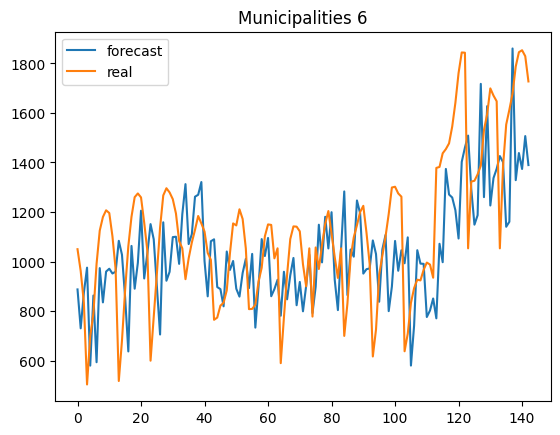

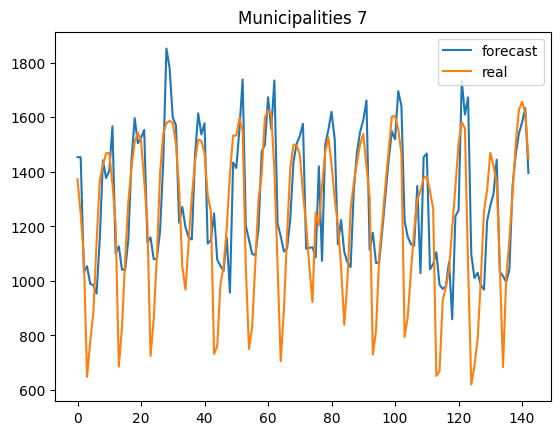

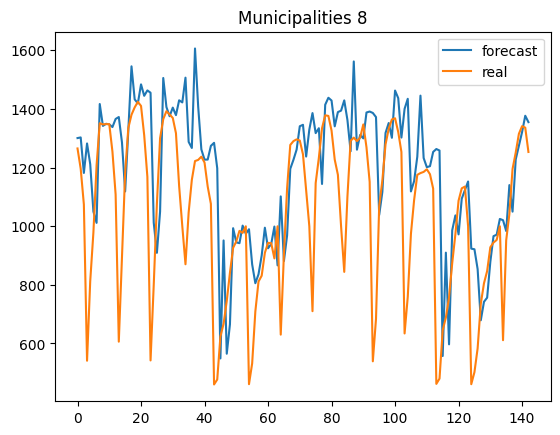

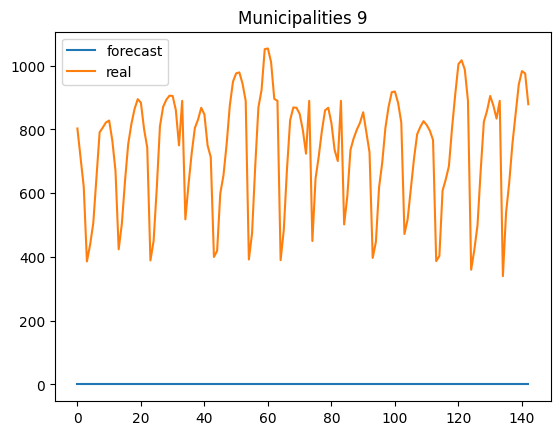

In [16]:
import matplotlib.pyplot as plt
for i in range(len(models)):
    plt.plot(yhats[i][:,0], label='forecast')
    plt.plot(y_tests[i][:,0], label='real')
    plt.title(f"Municipalities {i}")
    plt.legend()
    plt.show()

**Scores**

In [13]:
for i in range(len(models)):
    print(f"Municipality {i}")
    evaluate_forecast(y_tests[i][:, 0], yhats[i][:, 0])
    print("-------------")

Municipality 0
mae: tf.Tensor(238.70761, shape=(), dtype=float32)
mse: tf.Tensor(95869.15, shape=(), dtype=float32)
mape: tf.Tensor(45.01978, shape=(), dtype=float32)
-------------
Municipality 1
mae: tf.Tensor(71.90912, shape=(), dtype=float32)
mse: tf.Tensor(10274.152, shape=(), dtype=float32)
mape: tf.Tensor(27.836336, shape=(), dtype=float32)
-------------
Municipality 2
mae: tf.Tensor(106.68355, shape=(), dtype=float32)
mse: tf.Tensor(18349.514, shape=(), dtype=float32)
mape: tf.Tensor(23.707281, shape=(), dtype=float32)
-------------
Municipality 3
mae: tf.Tensor(238.23486, shape=(), dtype=float32)
mse: tf.Tensor(77635.19, shape=(), dtype=float32)
mape: tf.Tensor(26.15606, shape=(), dtype=float32)
-------------
Municipality 4
mae: tf.Tensor(418.01215, shape=(), dtype=float32)
mse: tf.Tensor(308978.66, shape=(), dtype=float32)
mape: tf.Tensor(22.273396, shape=(), dtype=float32)
-------------
Municipality 5
mae: tf.Tensor(72.328384, shape=(), dtype=float32)
mse: tf.Tensor(33223.05,

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
def evaluate_forecast_sklearn(y_test, yhat):
    """
    Evaluation metrics with tensorflow
    :param y_test: real target values of test values
    :param yhat: predicted target values from test values
    :return: evaluation scores
    """
    mae = mean_absolute_error(y_test,yhat)
    print('mae:', mae)
    mse = mean_squared_error(y_test,yhat)
    print('mse:', mse)
    mape = mean_absolute_percentage_error(y_test,yhat)
    print('mape:', mape)

In [15]:
for i in range(len(models)):
    print(f"Municipality {i}")
    evaluate_forecast_sklearn(y_tests[i][:, 0], yhats[i][:, 0])
    print("-------------")

Municipality 0
mae: 238.70758748087852
mse: 95869.14512701269
mape: 0.45019778067035127
-------------
Municipality 1
mae: 71.90911700197589
mse: 10274.151391262534
mape: 0.27836333316938255
-------------
Municipality 2
mae: 106.68353952023995
mse: 18349.513759164347
mape: 0.23707282014212602
-------------
Municipality 3
mae: 238.23485309449666
mse: 77635.1869363233
mape: 0.2615605768055522
-------------
Municipality 4
mae: 418.0121750577439
mse: 308978.65827267396
mape: 0.22273394717549375
-------------
Municipality 5
mae: 72.32838392991285
mse: 33223.0491006349
mape: 0.5519234518468116
-------------
Municipality 6
mae: 207.68541918015796
mse: 67187.34162172808
mape: 0.1961749718592679
-------------
Municipality 7
mae: 152.8911349067599
mse: 40072.384767970034
mape: 0.15112454381635912
-------------
Municipality 8
mae: 184.57601611441945
mse: 81642.29800493525
mape: 0.252406285754478
-------------
Municipality 9
mae: 742.2415501165501
mse: 581945.555737665
mape: 1.0
-------------
